# Notebook imports

In [52]:
from os import walk
from os.path import join

import pandas as pd

import matplotlib.pyplot as plt

# Constants

In [37]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1/'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2/'
NON_SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1/'
NON_SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2/'
SPAM = 1
NON_SPAM = 0

DATA_PATH = 'email-data.json'

# Reading Files

In [4]:
file = open(EXAMPLE_FILE, encoding='latin-1')
is_body = False
lines = []
for line in file:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
file.close()

email_body = '\n'.join(lines)

# Generator Functions

In [5]:
def generate_square(n):
    for number in range(n):
        yield number ** 2

generate_square(10)

<generator object generate_square at 0x00000215DD5834C8>

In [6]:
for i in generate_square(5):
    print(i, end=' ')

# สาเหตุที่ต้องใช้ก็คือมันมีการจำ state และเมื่อเราเล่นกับ dataset ใหญ่ๆ
# ลองนึกภาพว่าคำนวณก้อนเท่าบ้านออกมาอะ ขนาดข้อมูลนะ ใช้เวลานานมากด้วยกว่าจะรัน state ถัดไปได้

0 1 4 9 16 

# Email body extraction

In [7]:
def email_body_generator(path):
    for root, dir_names, file_names in walk(path):
        for file_name in file_names:
            file = open(join(root, file_name), encoding='latin-1')
            is_body = False
            lines = []
            for line in file:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True
            file.close()
            email_body = '\n'.join(lines)
            yield file_name, email_body 

In [8]:
def get_df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

In [9]:
df = get_df_from_directory(SPAM_1_PATH, SPAM)
df = df.append(get_df_from_directory(SPAM_2_PATH, SPAM))
df = df.append(get_df_from_directory(NON_SPAM_1_PATH, NON_SPAM))
df = df.append(get_df_from_directory(NON_SPAM_2_PATH, NON_SPAM))
df

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1
...,...,...
01396.61983fbe6ec43f55fd44e30fce24ffa6,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,"> >-- be careful when using this one.) Also, t...",0
01398.169b51731fe569f42169ae8f948ec676,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0


# Data cleaning: Checking for Missing Values

In [10]:
# check for missing valeus
print(df['MESSAGE'].isnull().values.any(None), '\n')
print(df['MESSAGE'].isnull().value_counts())

False 

False    5799
Name: MESSAGE, dtype: int64


In [11]:
# check for empty email
print((df['MESSAGE'].str.len() == 0).values.any(0), '\n')
print((df['MESSAGE'].str.len() == 0).value_counts())

True 

False    5796
True        3
Name: MESSAGE, dtype: int64


In [12]:
# locate emptry email
print(df['MESSAGE'].str.len()==0)
df[df['MESSAGE'].str.len()==0].index  # get the index, name which match given condition

00001.7848dde101aa985090474a91ec93fcf0    False
00002.d94f1b97e48ed3b553b3508d116e6a09    False
00003.2ee33bc6eacdb11f38d052c44819ba6c    False
00004.eac8de8d759b7e74154f142194282724    False
00005.57696a39d7d84318ce497886896bf90d    False
                                          ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6    False
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    False
01398.169b51731fe569f42169ae8f948ec676    False
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    False
01400.f897f0931e461e7b2e964d28e927c35e    False
Name: MESSAGE, Length: 5799, dtype: bool


Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [13]:
df.index.get_loc('cmds')  # return narray type: boolean
df[df.index.get_loc('cmds')]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


## Remove System file Entries from DataFrame

In [20]:
df.drop(['cmds'], inplace=True)  # inplace make chahge with df

KeyError: "['cmds'] not found in axis"

In [21]:
df.shape

(5796, 2)

In [53]:
doc_id = range(0, len(df.index))
df['id'] = doc_id
df['file_name'] = df.index
df = df.set_index('id')
df

,MESSAGE,CATEGORY,file_name
id,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,1
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,2
3,##############################################...,1,3
4,I thought you might like these:\n\n1) Slim Dow...,1,4
...,...,...,...
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,5791
5792,"> >-- be careful when using this one.) Also, t...",0,5792
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,5793


In [40]:
# save to file using pandas
df.to_json(DATA_PATH)
df.to_csv(DATA_PATH.replace('json', 'csv'))

# Explore & Data visualisation

In [49]:
df['CATEGORY'].value_counts()
non_spam_amount = df['CATEGORY'].value_counts()[0]
spam_amount = df['CATEGORY'].value_counts()[1]

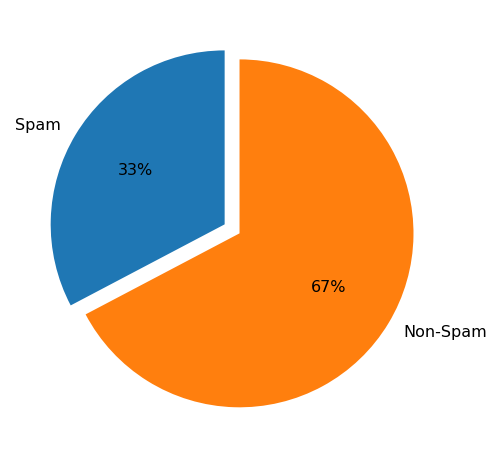

In [69]:
sizes = [spam_amount, non_spam_amount]
categ_names = ['Spam', 'Non-Spam']
plt.figure(figsize=[8, 8])
plt.pie(sizes, labels=categ_names, startangle=90, textprops={'fontsize': 16}, autopct='%1.0f%%',
        explode=[0, 0.1])
plt.show()

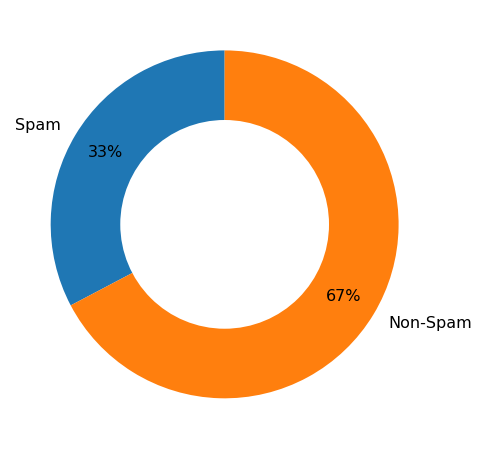

In [74]:
plt.figure(figsize=[8, 8])
plt.pie(sizes, labels=categ_names, startangle=90, textprops={'fontsize': 16}, autopct='%1.0f%%',
        pctdistance=0.8)
plt.gca().add_artist(plt.Circle((0, 0), radius=0.6, fc='white'))
plt.show()